In [ ]:
!pip install numpy_indexed

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas
import ast
import os
from PIL import Image
import time
import copy
import numpy_indexed as npi

In [ ]:
a = np.asarray([[4, 6, 6],[4, 4, 4]])
b = np.asarray([[6, 6, 6,4],[4, 3, 2, 4]])
count = 0
for i in range(a.shape[0]):
  count += min(npi.in_(a[i, :], b[i, :]).sum(), npi.in_(b[i, :], a[i, :]).sum())
print(count)

5


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Get parts list - use indices of each part as "label", for one-hot encoding
parts_list = []
with open('/content/drive/My Drive/APS360 Project/share/Data/Input/Datasets/BerendPartsList') as f:
  for line in f:
    word = line[:len(line) - 1] # get rid of '\n
    parts_list.append(int(word))

print(parts_list)

[4153825, 6104154, 6249125, 4210718, 4181135, 623224, 4621545, 4211166, 4121739, 6062574, 4567338, 4153827, 4539099, 306223, 6229071, 654126, 4550325, 4114319, 4165967, 4527943, 300424, 4181144, 6138173, 6177697, 6022023, 6028324, 6151663, 4121967, 4109995, 4211437, 4647553, 6035291, 306201, 4212454, 6073026, 4211201, 300401, 300421, 300821, 4529247, 4118793, 4504369, 6238674, 6069259, 6223631, 6022064, 300121, 300321, 300124, 4211614, 6225539, 300123, 4649749, 4651236, 4639693, 4157124, 4550348, 6244886, 6075079, 6025026, 4529240, 4558957, 4517992, 4548180, 614321, 6003007, 4211511, 4504381, 6252809, 4181134, 4211412, 300423, 4211149, 4650630, 6074890, 4160403, 4655172, 4211221, 4143562, 6075075, 6004938, 365901, 4211054, 4520632, 300323]


In [ ]:
csv_path = '/content/drive/My Drive/APS360 Project/share/Data/Input/Datasets/Berend/CSV/labels.csv'
image_path = '/content/drive/My Drive/APS360 Project/share/Data/Input/Datasets/Berend/Images'
bbox_label_root = '/content/drive/My Drive/APS360 Project/finalOutput'
data = pandas.read_csv(csv_path)
# Convert label col to list of ints of part numbers:
for i in range(len(data["Labels"])):
  label = data["Labels"][i]
  list_row = ast.literal_eval(label)
  data["Labels"][i] = list(map(int, list_row))
# Do same for Color column:
for i in range(len(data["Color"])):
  label = data["Color"][i]
  list_row = ast.literal_eval(label)
  data["Color"][i] = list(map(int, list_row))
print(data["Name"][707])

B_710


In [ ]:
# Let us only deal with the first 10 data points:
data_subset = data[:10]
print(data_subset)

  Name     Light  ...            Color                                Labels
0  B_0  daylight  ...  [130, 130, 130]                             [4650630]
1  B_1  daylight  ...  [130, 130, 130]                             [4650630]
2  B_2  daylight  ...  [130, 130, 130]                             [4650630]
3  B_3  daylight  ...  [130, 130, 130]                    [4650630, 6252809]
4  B_4  daylight  ...  [130, 130, 130]                    [4650630, 6252809]
5  B_5  daylight  ...  [130, 130, 130]                    [4650630, 6252809]
6  B_6  daylight  ...  [130, 130, 130]           [4650630, 6252809, 4211054]
7  B_7  daylight  ...  [130, 130, 130]           [4650630, 6252809, 4211054]
8  B_8  daylight  ...  [130, 130, 130]           [4650630, 6252809, 4211054]
9  B_9  daylight  ...  [130, 130, 130]  [4650630, 6252809, 4211054, 4548180]

[10 rows x 5 columns]


In [ ]:
label = data_subset["Name"][9]
print(label)
columns = ["Labels", "x_min", "y_min", "x_max", "y_max"]
bboxes = pandas.read_csv(os.path.join(bbox_label_root, label + '.csv'), skiprows=2, header=None, names=columns)
bboxes_np = bboxes.to_numpy()
print(bboxes_np)
print(type(bboxes_np[0, 0]))

B_9
[[6252809    1393    1643    2467    2598]
 [4548180    2619    1789    2910    2023]
 [4211054    2897    2497    3295    2769]
 [4650630    1551     209    1797     392]]
<class 'numpy.int64'>


In [ ]:
class BerendDataset(Dataset):
  # For our dataset, let us accept a CSV file as input
  # + a list of parts, for a one-hot encoding.
  # We will also accept a root directory for images. 
  # We also accept transformations to the image
  def __init__(self, csv_path, parts_list, image_root, transforms, bbox_root):
    self.csv_path = csv_path
    self.parts_list = parts_list
    self.image_root = image_root
    data = pandas.read_csv(csv_path)
    # Convert label col to list of ints of part numbers:
    for i in range(len(data["Labels"])):
      label = data["Labels"][i]
      list_row = ast.literal_eval(label)
      int_list = list(map(int, list_row))
      data["Labels"][i] = list(map(lambda x: parts_list.index(x), int_list))

    # Do same for Color column:
    for i in range(len(data["Color"])):
      label = data["Color"][i]
      list_row = ast.literal_eval(label)
      data["Color"][i] = torch.LongTensor(list(map(int, list_row)))
    
    self.data = data
    self.transforms = transforms
    self.bbox_root = bbox_root
    self.bbox_tracked = {}
    self._BBOX_COL_NAMES = ["Labels", "x_min", "y_min", "x_max", "y_max"]

  def __getitem__(self, idx):
    target = {}
    labels = self.data["Labels"][idx]

    filename = self.data["Name"][idx]
    #print(filename)
    img_path = os.path.join(self.image_root, filename + '.jpg')
    bbox_path = os.path.join(self.bbox_root, filename + '.csv')

    img = Image.open(img_path).convert("RGB")
    if self.transforms is not None:
      img = self.transforms(img)

    target["labels"] = torch.LongTensor(labels)

    if filename in self.bbox_tracked:
      bboxes = self.bbox_tracked[filename]
    else:
      bbox_data = pandas.read_csv(os.path.join(self.bbox_root, filename + '.csv'),
                                  skiprows=2,
                                  header=None,
                                  names=self._BBOX_COL_NAMES)
      bbox_data_np = bbox_data.to_numpy(dtype=np.int_)
      bbox_labels = bbox_data_np[:, 0]
      bbox_targets = bbox_data_np[:, 1:]
      bboxes = torch.zeros([len(labels), 4], dtype=torch.long)
      for i in range(len(bbox_labels)):
        bboxes[i, :] = torch.LongTensor(bbox_targets[i])
      self.bbox_tracked[filename] = bboxes

    target["boxes"] = bboxes
    
    return img, target
  def __len__(self):
        return len(self.data)

In [ ]:
data_transform = transforms.Compose([transforms.Resize((375, 500)), transforms.ToTensor()])
dataset = BerendDataset(csv_path=csv_path, parts_list=parts_list, image_root=image_path, transforms=data_transform, bbox_root=bbox_label_root)

In [ ]:
item = dataset[9]

(tensor([[[0.3020, 0.3059, 0.3020,  ..., 0.3529, 0.3647, 0.3922],
         [0.3490, 0.3647, 0.3412,  ..., 0.3529, 0.3843, 0.4157],
         [0.3490, 0.3686, 0.3765,  ..., 0.3882, 0.3961, 0.3843],
         ...,
         [0.4706, 0.4980, 0.5098,  ..., 0.4510, 0.4510, 0.4627],
         [0.4667, 0.4784, 0.4941,  ..., 0.4510, 0.4510, 0.4667],
         [0.4471, 0.4667, 0.4588,  ..., 0.4549, 0.4549, 0.4667]],

        [[0.2706, 0.2627, 0.2588,  ..., 0.3176, 0.3255, 0.3451],
         [0.3137, 0.3176, 0.3098,  ..., 0.3059, 0.3294, 0.3686],
         [0.3098, 0.3216, 0.3451,  ..., 0.3412, 0.3569, 0.3608],
         ...,
         [0.5412, 0.5765, 0.5725,  ..., 0.4549, 0.4549, 0.4549],
         [0.5294, 0.5647, 0.5490,  ..., 0.4471, 0.4471, 0.4667],
         [0.4824, 0.5176, 0.5137,  ..., 0.4471, 0.4392, 0.4588]],

        [[0.1608, 0.1647, 0.1529,  ..., 0.2706, 0.2667, 0.3020],
         [0.1922, 0.2118, 0.1843,  ..., 0.2549, 0.2902, 0.3294],
         [0.1961, 0.2039, 0.2000,  ..., 0.2667, 0.3020, 0

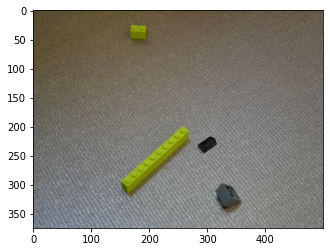

In [ ]:
print(item)
image, target = item
img = np.transpose(image, [1,2,0])
print(img.shape)
plt.imshow(img)
print(target["boxes"])

In [ ]:
print(len(dataset))

816


In [ ]:
import torchvision

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.num_classes = len(parts_list)
print(model)
image = image.unsqueeze(0)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [ ]:
model.roi_heads.box_predictor.cls_score = nn.Linear(in_features=1024, out_features=len(parts_list), bias=True)
model.roi_heads.box_predictor.bbox_pred = nn.Linear(in_features=1024, out_features=4*len(parts_list), bias=True)

In [ ]:
model.eval()
out = model(image)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [ ]:
print(out)

[{'boxes': tensor([[249.0785, 200.0316, 266.1404, 226.0376],
        [238.1294, 202.0174, 262.6299, 236.5703],
        [198.9855, 190.8295, 251.2606, 250.4472],
        [219.1702, 177.9651, 265.1850, 256.7671],
        [254.4208, 202.1338, 264.5929, 215.0754]], grad_fn=<StackBackward>), 'labels': tensor([52, 52, 52, 52, 52]), 'scores': tensor([0.0789, 0.0728, 0.0656, 0.0656, 0.0650], grad_fn=<IndexBackward>)}]


In [ ]:
model.train()
img, label = dataset[3]
img = img.unsqueeze(0)
label = [label]
print(img.shape)
print(label)



torch.Size([1, 3, 375, 500])
[{'labels': tensor([73, 68]), 'boxes': tensor([[1990,  795, 2297, 1079],
        [1579, 1598, 2992, 2363]])}]


In [ ]:
out = model(img, label)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [ ]:
print(out)

{'loss_classifier': tensor(4.3160, grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(3.7283e-06, grad_fn=<DivBackward0>), 'loss_objectness': tensor(19.5085, grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(236.2709, grad_fn=<DivBackward0>)}


In [ ]:
out['loss_classifier'].backward()

In [ ]:
#train_length = int(0.6*len(dataset))
#val_length = int(0.2*len(dataset))
train_length = 20
val_length = 20
test_length = len(dataset) - train_length - val_length
torch.manual_seed(42)
trainset, valset, testst = torch.utils.data.random_split(dataset,
                                                         [train_length, val_length, test_length])

In [ ]:
#trainloader = torch.utils.data.DataLoader(trainset, batch_size=32)

In [ ]:
def collate_fn(batch):
  images = []
  targets = []
  for lego in batch:
    images.append(lego[0])
    targets.append(lego[1])
  
  return images, targets



In [ ]:
class Batcher:
    def __init__(self, dataset, batch_size=32, drop_last=False):
        self.pics_by_length = {}
        for image, target in dataset:
            # compute the length of the labels:
            llen =target["labels"].shape[0]
            # put the data in the correct key inside self.tweet_by_length
            if llen not in self.pics_by_length:
                self.pics_by_length[llen] = []
            self.pics_by_length[llen].append((image, target),)
         
        #  create a DataLoader for each set of tweets of the same length
        self.loaders = {llen : torch.utils.data.DataLoader(
                                    legos,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=drop_last,   # omit last batch if smaller than batch_size
                                    collate_fn=collate_fn)
            for llen, legos in self.pics_by_length.items()}
        
    def __iter__(self): # called by Python to create an iterator
        # make an iterator for every tweet length
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            # pick an iterator (a length)
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                # no more elements in the iterator, remove it
                iters.remove(im)

In [ ]:
trainloader = Batcher(trainset, batch_size=2, drop_last=True)
'''
for i, (image, target) in enumerate(Batcher(trainset,zy drop_last=True)):
    if i >= 0:
      print(image.shape, target) 
      break
'''

'\nfor i, (image, target) in enumerate(Batcher(trainset,zy drop_last=True)):\n    if i >= 0:\n      print(image.shape, target) \n      break\n'

In [ ]:
val_loader = Batcher(valset, batch_size=2, drop_last=True)

In [ ]:
'''for images, target in val_loader.loaders[1]:
  model = model.cuda()
  for i in range(len(images)):
    inputs[i] = inputs[i].cuda()
    target[i]["labels"] = target[i]["labels"].cuda()
    target[i]["boxes"] = target[i]["boxes"].cuda()
  out = model(images, target)
  break'''

'for images, target in val_loader.loaders[1]:\n  model = model.cuda()\n  for i in range(len(images)):\n    inputs[i] = inputs[i].cuda()\n    target[i]["labels"] = target[i]["labels"].cuda()\n    target[i]["boxes"] = target[i]["boxes"].cuda()\n  out = model(images, target)\n  break'

In [ ]:
#print(out)

In [ ]:
def get_metrics(model, dataloader):
  model.eval()
  count = 0
  total_predictions = 0
  total_labels = 0
  for inputs, target in dataloader:
    for i in range(len(inputs)):
      inputs[i] = inputs[i].cuda()
      target[i]["labels"] = target[i]["labels"].cuda()
      target[i]["boxes"] = target[i]["boxes"].cuda()
  
    outputs = model(inputs)
    for i in range(len(outputs)):
      label = (target[i]["labels"]).cpu().numpy()
      pred = outputs[i]['labels'].cpu().numpy()
      # Get number of true positives:
      count += min(npi.in_(pred, label).sum(), npi.in_(pred, label).sum())
      # Get total number of predictions:
      total_predictions += len(pred)
      total_labels += len(label)
      # print(label, pred)
  # Precisions = TP/(TP + FP)
  print(count, total_predictions, total_labels)
  if (total_predictions == 0):
    precision = 0
  else:
    precision = count/total_predictions

  if (total_labels == 0):
    recall = 0
  else:
    recall = count/total_labels
  return (precision, recall)

In [ ]:
def train_model(model, optimizer, trainloader, val_loader, num_epochs=25):
    torch.manual_seed(42)
    since = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        n = 0
        for inputs, target in trainloader:
            for i in range(len(inputs)):
              inputs[i] = inputs[i].cuda()
              target[i]["labels"] = target[i]["labels"].cuda()
              target[i]["boxes"] = target[i]["boxes"].cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs, target)
                #preds = torch.max(outputs, 1)
                class_loss = outputs['loss_classifier']

                class_loss.backward()
                optimizer.step()
                # statistics
                running_loss += class_loss.item()
                #running_corrects += torch.sum(preds == target)
                n+=1
            #print("Epoch {}, iteration {}".format(epoch, n))
                  

        epoch_loss = running_loss / n
        #epoch_acc = running_corrects.double() / n

        print('Training Loss: {:.4f}'.format(epoch_loss))
        #print('Training Acc: {:.4f}'.format(epoch_acc))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    """
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    """
    return model

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model.parameters(), lr=1e-5)
model = model.cuda()

In [ ]:
model_ft = train_model(model, optimizer_ft, trainloader, val_loader,
                       num_epochs=10)

Epoch 0/9
----------


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Training Loss: 0.1776

Epoch 1/9
----------
Training Loss: 0.0363

Epoch 2/9
----------
Training Loss: 0.0359

Epoch 3/9
----------
Training Loss: 0.0359

Epoch 4/9
----------
Training Loss: 0.0357

Epoch 5/9
----------
Training Loss: 0.0357

Epoch 6/9
----------
Training Loss: 0.0355

Epoch 7/9
----------
Training Loss: 0.0357

Epoch 8/9
----------
Training Loss: 0.0357

Epoch 9/9
----------
Training Loss: 0.0358

Training complete in 47m 21s


In [ ]:
class FastRCNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FastRCNN, self).__init__()
        self.fc1 = nn.Linear(4096, num_classes*4)
        self.fc2 = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))


In [ ]:
# for each pixel on the feature map, need to generate 9 anchor boxes
# feed in the center point of the feature
# output the x1, y1, x2, y2 coordinates for each box

class RPN(nn.Module):
    def __init__(self, ratio=[0.5, 1, 2], anchor_size=[8, 16, 32]):
        Super(RPN, self).__init__()
        self.ratio = ratio
        self.anchor_size = anchor_size
        self.num_anchors = len(ratio)*len(anchor_size)
